In [1]:
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import intmcp.plot as plot_lib
import intmcp.plot._parts as parts

# Change this to plot different problem
problem_name = "rc"

# Change dir name to use different base dir
exp_results_dir = 'rc/num_sims/'

df, results_dir = plot_lib.load_results(problem_name, exp_results_dir, iros=True)

print(plot_lib.results_summary(df, include_headers=False))

agent_i = 0
agent_j = 1

Num Exps = 145
Agent IDs = [0 1]
Num Sims = [   1   16  128  512 1024 2048 4096]
Nesting levels = [0 1 2 3]
Step Limits = [20]
Policy Classes = ['NestedSearchTree' 'RCNestedReasoningPolicy' 'RandomPolicy']
Rollout Policies = ['None']


In [2]:
# Remove all rows in df where agent j == RandomPolicy
random_j_df = df[(df[parts.POLICY_KEY] == 'RandomPolicy') & (df[parts.AGENT_ID_KEY] == agent_j)]
exp_ids = random_j_df[parts.EXP_ID_KEY].unique()
df = df[~df.exp_id.isin(exp_ids)]
print(df[parts.POLICY_KEY].unique())

['RCNestedReasoningPolicy' 'NestedSearchTree' 'RandomPolicy']


/home/jonathon/Code/i-ntmcp/intmcp/plot/_plot_pairwise_pis_y_by_x.py:202: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lines, **legend_kwargs)


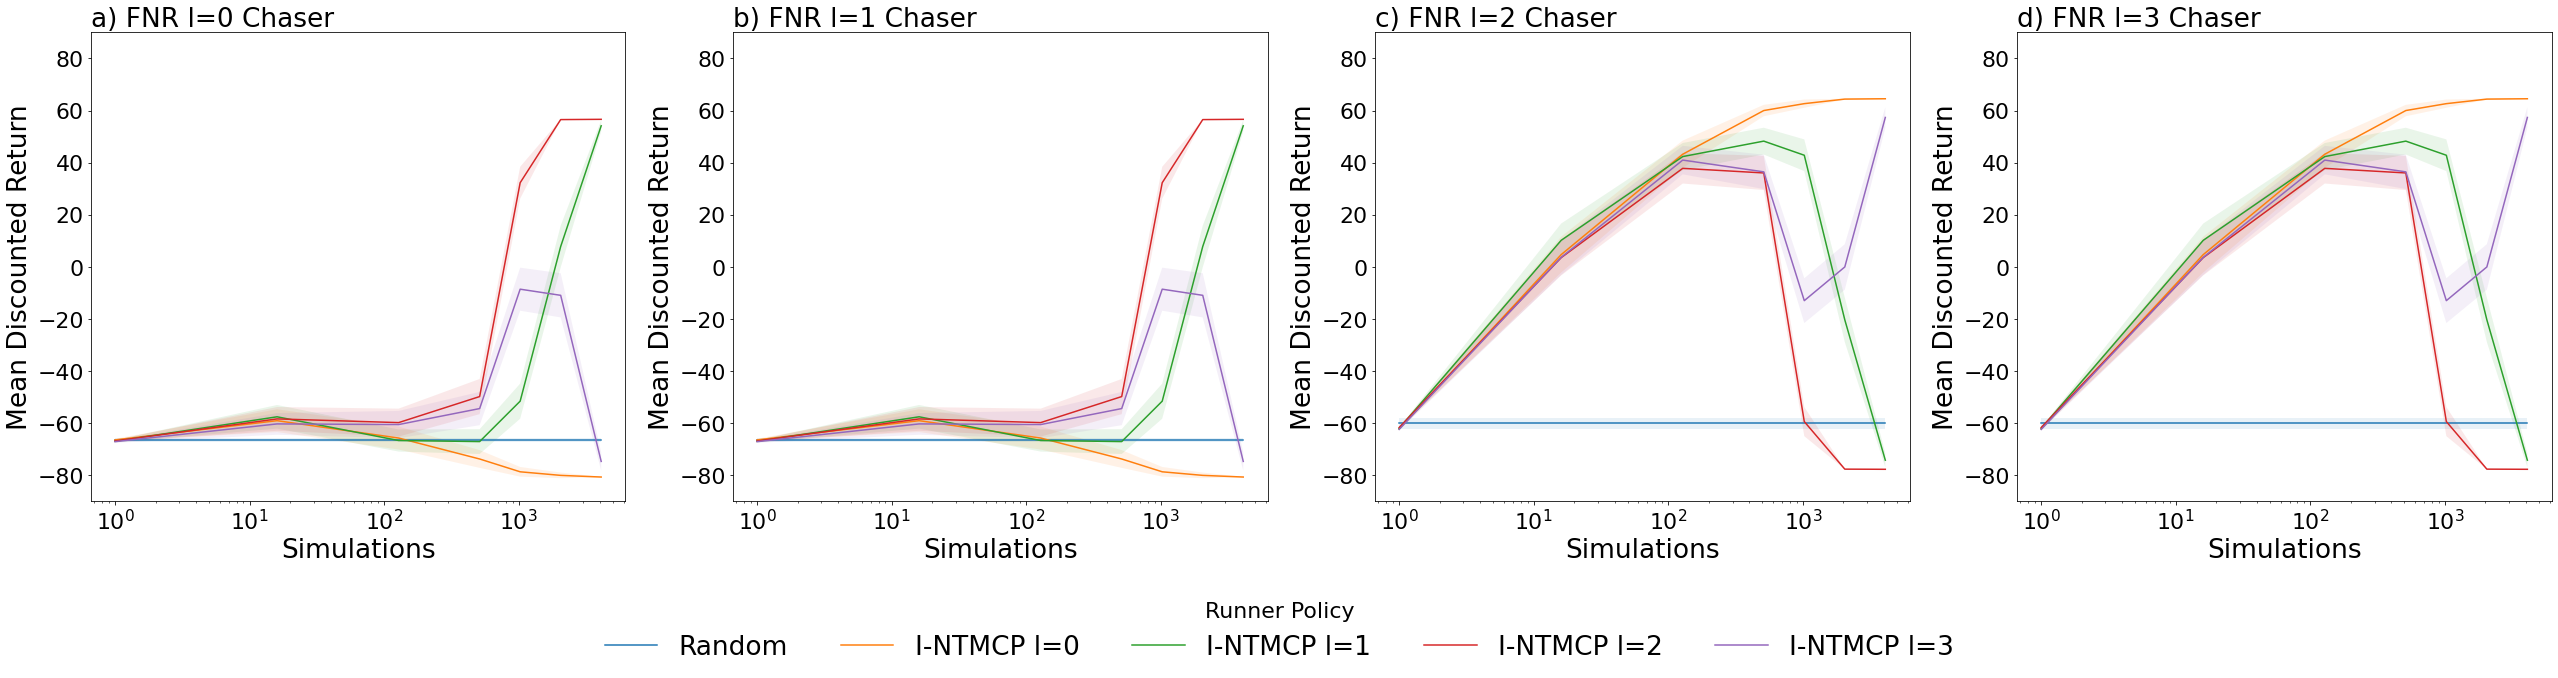

In [11]:
plot_lib.plot_pairwise_pis_y_by_x(
    df, 
    x_key="num_sims",
    y_key="episode_discounted_returns_mean", 
    y_err_key="episode_discounted_returns_CI",
    agent_i_id=agent_i,
    agent_j_id=agent_j,
    results_dir=results_dir,
    **{
        "ylabel": "Mean Discounted Return",
        "xlabel": "Simulations",
        "sharex": False,
        "sharey": False,
        "fontsize": 'large',
        "ylim": (-90, 90),
        "logx": True,
        "logy": False,
        "axes_titles": ["a) FNR l=0 Chaser", "b) FNR l=1 Chaser", "c) FNR l=2 Chaser", "d) FNR l=3 Chaser"],
        "axes_title_kwargs": {
            "fontsize": 'large',
            "loc": "left"
        },
        "legend_kwargs": {
            'title': "Runner Policy",
            'fontsize': 'large',
            "bbox_to_anchor": [0.5, 0.0],
            "loc": 'center',
            "ncol": 5,
            "frameon": False
        }
    }
)

/tmp/ipykernel_1111033/1336577718.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_exclude_df = time_df[
/home/jonathon/Code/i-ntmcp/intmcp/plot/_plot_pairwise_pis_y_by_x.py:202: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lines, **legend_kwargs)


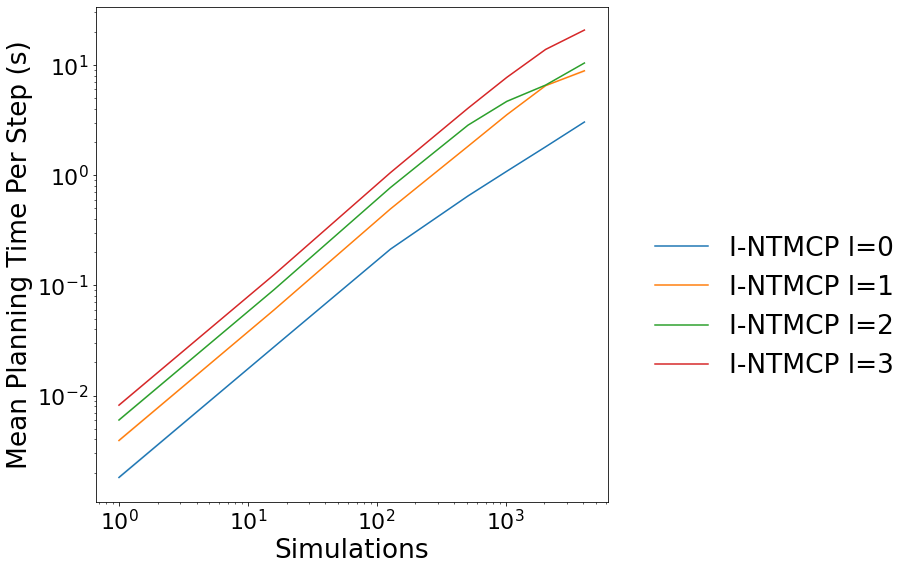

In [6]:
# Want to remove all rows in df where agent j == RandomPolicy
to_exclude_df = df[
    (df[parts.AGENT_ID_KEY] == agent_j)
    & (df[parts.POLICY_KEY] == 'RCNestedReasoningPolicy')
    & (df.nesting_level.isin([1, 2, 3]))
]
exp_ids = to_exclude_df[parts.EXP_ID_KEY].unique()
time_df = df[~df.exp_id.isin(exp_ids)]

to_exclude_df = time_df[
    (df[parts.AGENT_ID_KEY] == agent_i)
    & (df[parts.POLICY_KEY] == 'RandomPolicy')
]
exp_ids = to_exclude_df[parts.EXP_ID_KEY].unique()
time_df = time_df[~time_df.exp_id.isin(exp_ids)]

plot_lib.plot_pairwise_pis_y_by_x(
    time_df, 
    x_key='num_sims',
    y_key="search_time_mean", 
    y_err_key="search_time_CI",
    agent_i_id=agent_i,
    agent_j_id=agent_j,
    results_dir=results_dir,
    **{
        "ylabel": "Mean Planning Time Per Step (s)",
        "xlabel": "Simulations",
        "sharex": False,
        "sharey": False,
        "logx": True,
        "logy": True,
        "fontsize": 'large',
        "axes_titles": [""],
        "axes_title_kwargs": {
            "fontsize": 'large',
            "loc": "left"
        },
        "legend_kwargs": {
            'fontsize': 'large',
            "bbox_to_anchor": [1.0, 0.5],
            "loc": 'center left',
            "ncol": 1,
            "frameon": False
        }
    }
)